# The Latin Square Task (LST)

Each LST “puzzle” involves the presentation of a four-by-four matrix populated with a small number of geometric shapes (squares, circles, triangles, or crosses), blank spaces, and a single target, denoted by a yellow question mark. Participants were asked to solve for the target according to the following rule: each shape can only occur once in every row and once in every column (similar to the game of sudoku). Binary problems require integration of information across a single row or column. Ternary problems involve integration across a single row and column. Quaternary problems, the most complex, require integration of information across multiple rows and columns. (_More on these definitions later._)

It's basically a small sudoku with only one target. In the fMRI paper we used shapes but you could use numbers, or colours or whatever.

Here is a figure from the paper:

![](https://www.jneurosci.org/content/jneuro/37/35/8399/F1.large.jpg?width=800&height=600&carousel=1)

## Working memory steps and what to do with them

The following figure from Hartung et al., (https://doi.org/10.1016/j.intell.2022.101683) nicely demonstrates the problem you encounter when a problem can be solved in two different ways (__panel D__).

Note that the authors call 'Binary problems' __one vector__, Ternary problemns __two vector__, and quaternary problems __three vector__ (which makes more sense IMO).

![](https://ars.els-cdn.com/content/image/1-s2.0-S0160289622000642-gr1.jpg)

In relational complexity theory you would say the final problem is the lowest level of complexity needed to solve the problem (two steps of one vector). But I agree with the authors that a better way to think about this is as a "shortest path". In which case it is a 'two vector' problem.

## Looking at our testing data
The testing data (i.e., the fMRI data) where designed by someone else from the relational complexity camp. None of these problems have two steps.

In [1]:
from lstnn.dataset import get_dataset
import pandas as pd

# the original dataset in csv form
df = pd.read_csv('../data/nn/puzzle_data_original.csv')
df.head()

,ID,LST_num,condition,puzzles,solutions
0,0,1,Binary,40405210200030,1
1,1,1,Binary,210000043510030,2
2,2,1,Binary,100040345020200,3
3,3,2,Binary,1000004054124020,3
4,4,2,Binary,1502010032100300,4


Each problem is stored as a vector of length 16 where '0' denotes blank spaces and '5' denotes a target. In the fMRI experiment there were 36 problems in each condition, so the first 36 problems are Binary, the next are Ternary and the final 36 are Quaternary.

In [2]:
# create the dataset and print some puzzles
dataset = get_dataset(['../data/nn/puzzle_data_original.csv'])
dataset.print_puzzle(35)

(tensor([[0, 0, 1, 0],
         [0, 0, 2, 0],
         [1, 2, 3, 4],
         [5, 3, 4, 1]]),
 tensor(2))

In [3]:
dataset = get_dataset(['../data/nn/puzzle_data_steps_original.csv'])
dataset.print_puzzle(35)

(tensor([[0, 0, 1, 0],
         [0, 0, 2, 0],
         [1, 2, 3, 4],
         [5, 3, 0, 1]]),
 tensor(2))

In [4]:
dataset.print_puzzle(40)

(tensor([[0, 0, 0, 0],
         [1, 0, 5, 2],
         [4, 0, 0, 0],
         [0, 4, 3, 1]]),
 tensor(4))

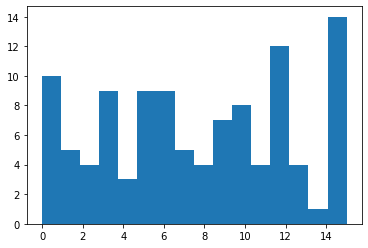

In [24]:
# let's see where all the targets are
import numpy as np
import matplotlib.pyplot as plt
targets = dataset.puzzles[:, :, :, -1].numpy()
plt.hist(np.where(targets.reshape(108, 16))[1], bins=16)
plt.show()

## Looking at our training data

A simple binary problem - you only need the target's column to solve the problem:

In [ ]:
# create the dataset and print some puzzles
train_puzzles, train_solutions = puzzles_to_tensor(['generated_puzzle_data_binary.csv'])
train_dataset = PuzzleDataset(train_puzzles,train_solutions)
train_dataset.print_puzzle(0)

A ternary problem - you need the column and the row to solve the problem _in the shortest step possible_

In [ ]:
# create the dataset and print some puzzles
train_puzzles, train_solutions = puzzles_to_tensor(['generated_puzzle_data_ternary.csv'])
train_dataset = PuzzleDataset(train_puzzles,train_solutions)
train_dataset.print_puzzle(999)

Now Quaternary (or three vector). In this one the shortest step is integrating information across all three blanks in the bottom row. 
- Bottom left (cell 13) _cannot be_ 2
- Cell 14 _cannot be_ 2
- Cell 15 _cannot be_ 2
- Therefore target must be 2

In [ ]:
# create the dataset and print some puzzles
train_puzzles, train_solutions = puzzles_to_tensor(['generated_puzzle_data_quaternary.csv'])
train_dataset = PuzzleDataset(train_puzzles,train_solutions)
train_dataset.print_puzzle(101)

## We can check the complexity of puzzles using verify_LST
Verify_LST prints the calculated complexity, the solution and the strategy the code used to find the solution.

In our training data every LST was verified using this code.

In [ ]:
from generate_training_data import verify_LST
verify_LST(train_dataset.print_puzzle(101)[0].numpy())

### How does verify_LST work exactly?

It is very dumb and doesn't actually solve puzzles. For binary and ternary the code is pretty trivial. 
- For Binary it just checks if three unique digits are in the targets row or column.
- For Ternary (assuming the above is not true) it checks if three unique digits are in the targets row / column
- For Quaternary (assuming the above is not true) it employs a number of strategies that I observed in the test dataset. I do think that this covers all possible strategies in a 4 x 4 matrix but will quickly break down with larger matrices (or become intractable)